In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [4]:
import cesium
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from cesium import datasets
from cesium import featurize as ft

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
print(cesium.__version__)
print(xgb.__version__)
print(scipy.__version__)
print(sklearn.__version__)

0.12.1
2.0.3
1.13.1
1.5.0


## Load data and generate some features of interest

In [6]:
eeg = datasets.fetch_andrzejak()

In [48]:
len(eeg['measurements'])

500

In [45]:
np.size(eeg['measurements'])

2048500

In [8]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [32]:
eeg

{'times': [array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
         2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
  array([0.00000000e+00

### Visually inspect

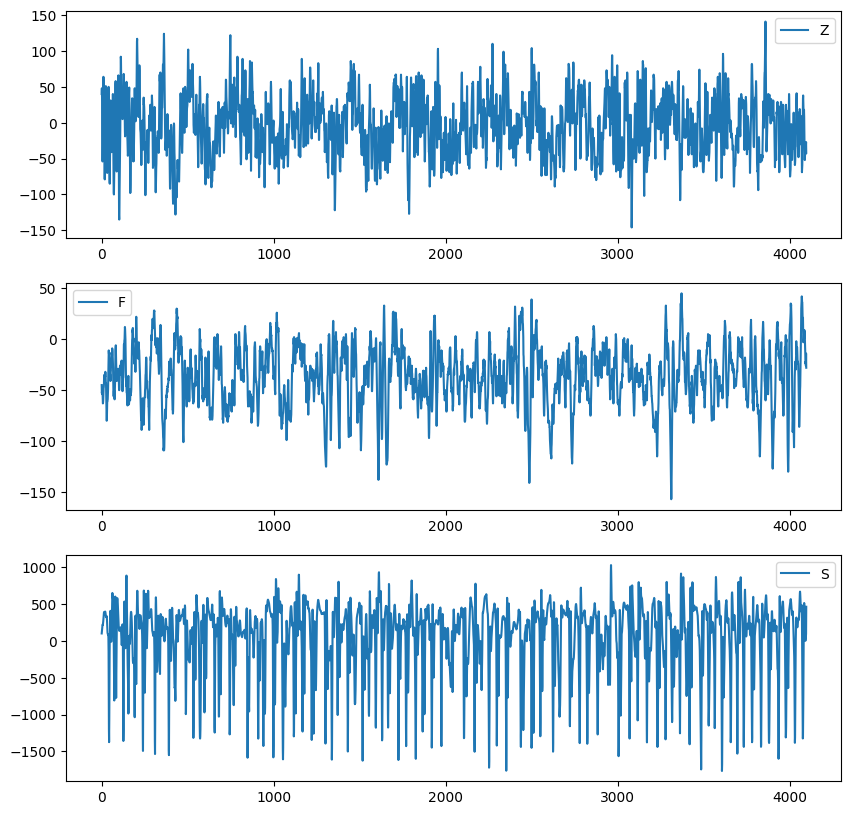

In [50]:
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][499])
plt.legend(eeg['classes'][499])

In [10]:
type(eeg["measurements"][0])

numpy.ndarray

In [11]:
type(eeg)

dict

In [12]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [13]:
type(eeg['measurements'])

list

In [ ]:
len(eeg['measurements'])

In [ ]:
eeg['measurements'][0].shape

## Generate the features

In [15]:
from cesium import featurize as ft
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                  "skew",
                  "max_slope"]
fset_cesium = ft.featurize_time_series(times=eeg["times"],
                                              values=eeg["measurements"],
                                              errors=None,
                                              features_to_use=features_to_use,
                                             scheduler = None)

In [ ]:
# fset_cesium = pd.read_csv("data/full_eeg_data_features.csv", header = [0, 1])

In [16]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


In [17]:
fset_cesium.to_csv("full_eeg_data_features.csv")

In [18]:
fset_cesium.shape

(500, 5)

## Exercise: validate/calculate these features by hand
#### look up feature definitions here: http://cesium-ml.org/docs/feature_table.html
confirm the values by hand coding these features for the first EEG measurement
(that is eeg["measurements"][0])

In [40]:
type(eeg['measurements'])
eeg['measurements']


[array([ 40.,  48.,  35., ..., -34., -27., -42.]),
 array([ -56.,  -50.,  -64., ..., -173., -162.,  -82.]),
 array([-37., -22., -17., ...,   3.,   4.,  82.]),
 array([-31., -43., -39., ...,  -6.,  10.,  33.]),
 array([ 14.,  26.,  32., ..., -32.,  -6., -17.]),
 array([-87., -89., -73., ...,  18.,   7.,   7.]),
 array([ -2.,  20.,  42., ..., -18.,  -6., -37.]),
 array([-31., -16.,  10., ...,   1.,   1.,   0.]),
 array([  8.,  17.,  29., ..., -40., -36.,   7.]),
 array([-41., -38., -31., ...,   1., -13.,  -1.]),
 array([ 14.,  25.,  31., ..., -26., -28.,  21.]),
 array([-64., -72., -52., ..., -36., -58.,  20.]),
 array([ 10.,  -6., -14., ...,  15.,   6., -46.]),
 array([31., 25., 17., ..., 23., 28., 65.]),
 array([ 30.,  19.,  -3., ..., -11., -13.,  -6.]),
 array([ 34.,  34.,  31., ...,  -7., -20.,  91.]),
 array([-62., -55., -44., ..., -20., -22.,  35.]),
 array([-18.,  -9.,   9., ..., 109.,  67.,  50.]),
 array([  0.,   2.,  -1., ...,  23.,  21., -16.]),
 array([-20.,  -3.,   2., ..., 

## An Example EEG Series is NOw Investigated

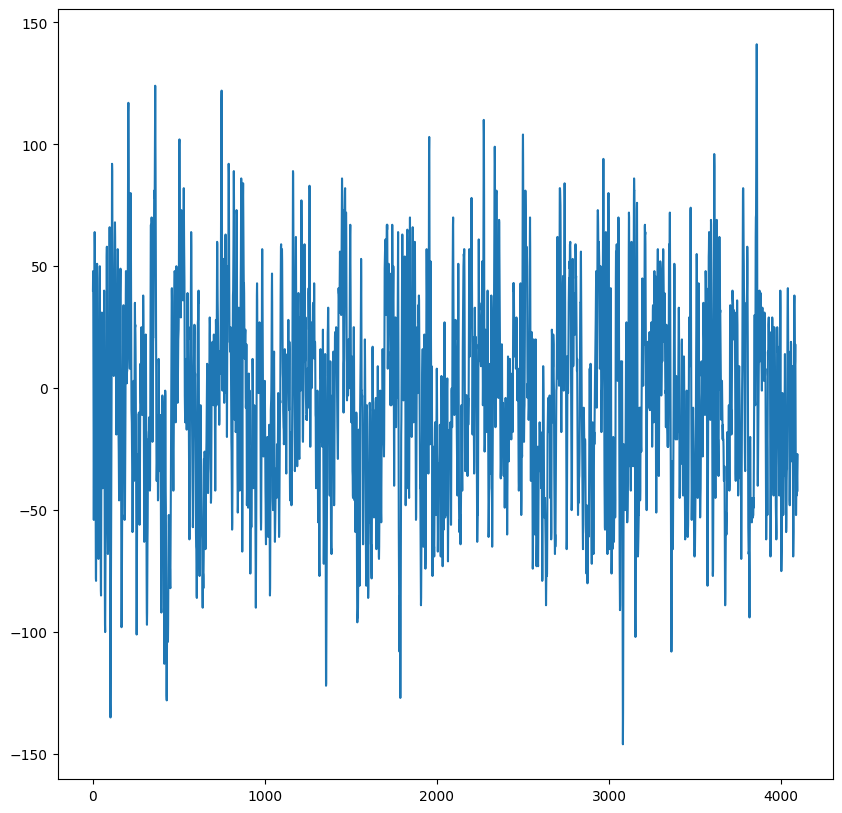

In [41]:
ex = eeg["measurements"][0]

plt.plot(ex)

In [36]:
ex

array([ 40.,  48.,  35., ..., -34., -27., -42.])

In [20]:
ex_mean = np.mean(ex)
ex_std  = np.std(ex)

In [21]:
# amplitude
(np.max(ex) - np.min(ex)) / 2

143.5

In [22]:
 
siz = len(ex)
ll = ex_mean - ex_std
ul = ex_mean + ex_std

quals = [i for i in range(siz) if ex[i] < ll or ex[i] > ul]
len(quals)/len(ex)

0.3273126678057115

In [23]:
# percent_close_to_median
# Percentage of values within window_frac*(max(x)-min(x)) of median.
# find the source code here:
# https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
# window frac = 0.1
window = 0.1 * (np.max(ex) - np.min(ex))
np.where(np.abs(ex_mean - ex) < window)[0].shape[0] / ex.shape[0]

0.5050036612155235

0.03280499636078603

0.03280499636078603


(array([  10.,   57.,  276.,  730., 1048., 1042.,  621.,  263.,   42.,
           8.]),
 array([-146. , -117.3,  -88.6,  -59.9,  -31.2,   -2.5,   26.2,   54.9,
          83.6,  112.3,  141. ]),
 <BarContainer object of 10 artists>)

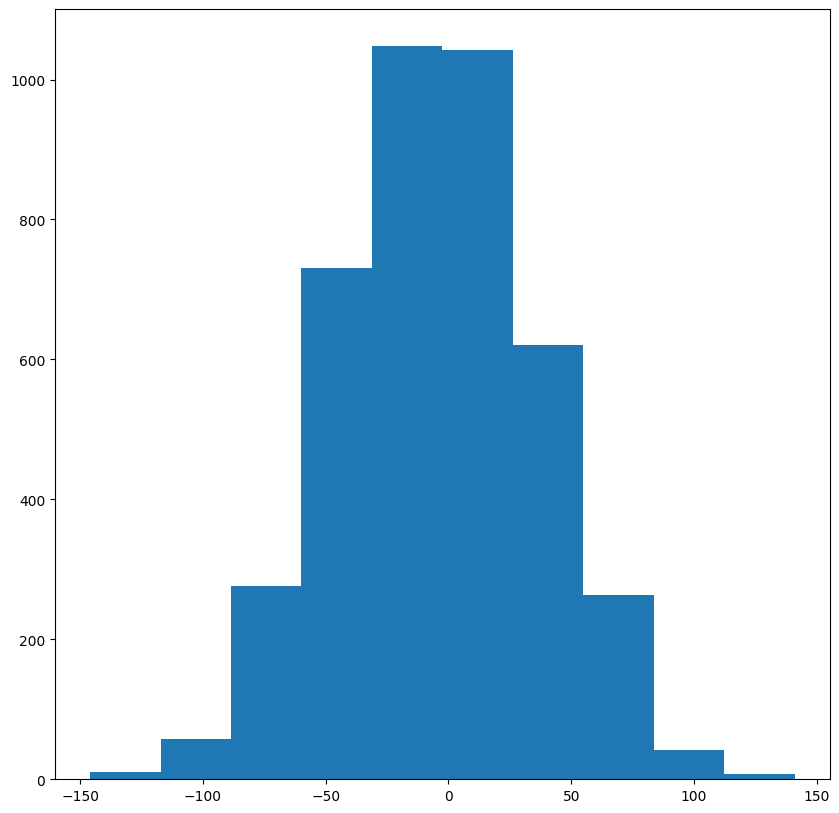

In [24]:
## skew
print(skew(ex))
plt.hist(ex)

In [25]:
## max slope
## again check definition : https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
times = eeg["times"][0]
np.max(np.abs(np.diff(ex)/np.diff(times)))

11107.796610166752

In [53]:
fset_cesium

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope,classes
0,143.5,0.327313,0.505004,0.032805,11107.796610,Z
1,211.5,0.290212,0.640469,-0.092715,20653.559322,Z
2,165.0,0.302660,0.515987,-0.004100,13537.627119,Z
3,171.5,0.300952,0.541128,0.063678,17008.813559,Z
4,170.0,0.305101,0.566268,0.142753,13016.949153,Z
...,...,...,...,...,...,...
495,876.5,0.368318,0.364413,-0.472757,94242.711864,S
496,433.0,0.361728,0.394923,0.046880,27595.932203,S
497,1359.0,0.270442,0.628265,-0.468130,243156.610169,S
498,1590.0,0.305589,0.489138,-0.674034,176856.949153,S


In [52]:
type(fset_cesium)

pandas.core.frame.DataFrame

In [61]:
len(fset_cesium.columns)

6

In [67]:
header = fset_cesium.head
print(header)

<bound method NDFrame.head of feature  amplitude  percent_beyond_1_std  percent_close_to_median      skew  \
0            143.5              0.327313                 0.505004  0.032805   
1            211.5              0.290212                 0.640469 -0.092715   
2            165.0              0.302660                 0.515987 -0.004100   
3            171.5              0.300952                 0.541128  0.063678   
4            170.0              0.305101                 0.566268  0.142753   
..             ...                   ...                      ...       ...   
495          876.5              0.368318                 0.364413 -0.472757   
496          433.0              0.361728                 0.394923  0.046880   
497         1359.0              0.270442                 0.628265 -0.468130   
498         1590.0              0.305589                 0.489138 -0.674034   
499         1396.0              0.225775                 0.606785 -1.347758   

feature      max_slop

## All the Histograms Plotted here

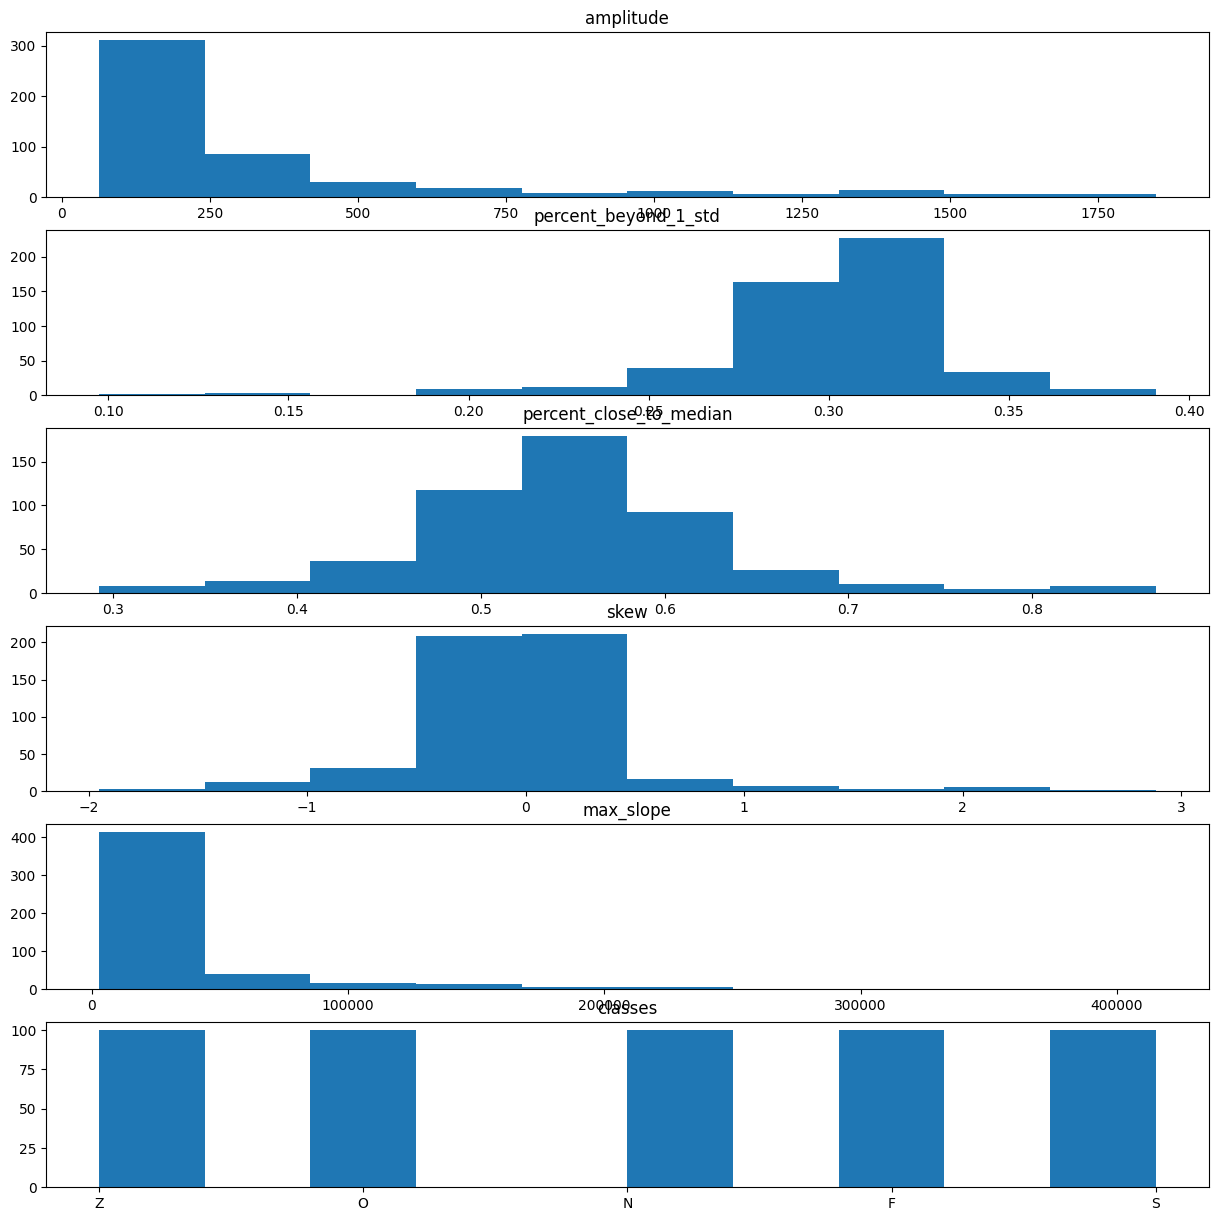

In [70]:
plt.figure(figsize=(15, 15))
num_columns=len(fset_cesium.columns)
header = fset_cesium.columns 
for i in range(num_columns):
     plt.subplot(num_columns, 1, i + 1)
     plt.title(header[i])
     plt.hist(fset_cesium.iloc[:, i])

(array([311.,  85.,  30.,  19.,   8.,  13.,   7.,  14.,   7.,   6.]),
 array([  63. ,  241.5,  420. ,  598.5,  777. ,  955.5, 1134. , 1312.5,
        1491. , 1669.5, 1848. ]),
 <BarContainer object of 10 artists>)

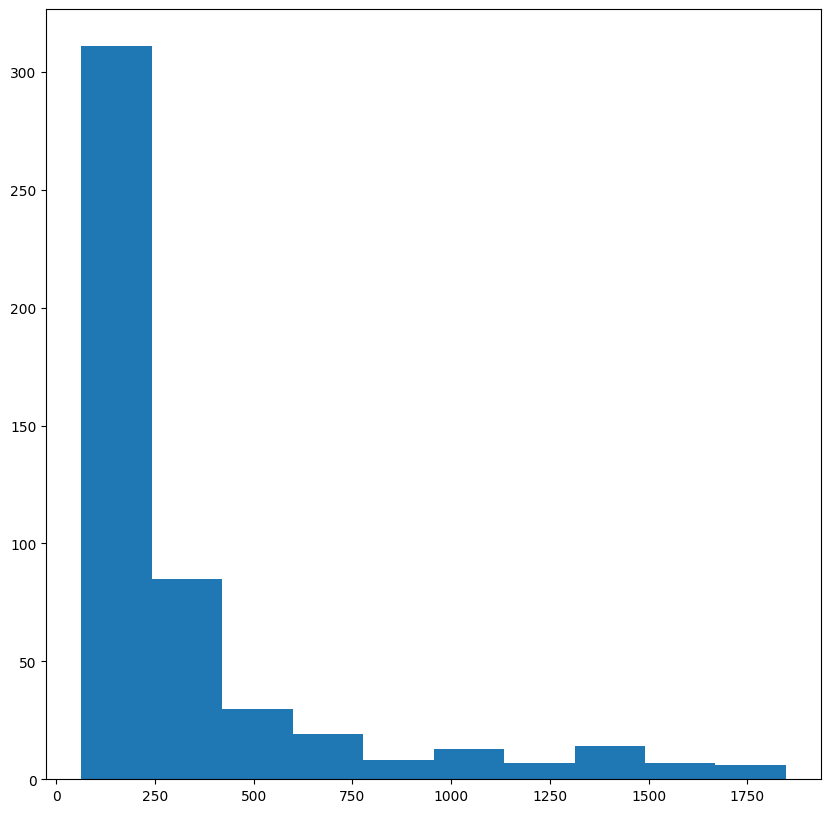

In [54]:
# only plotting the amplitude for all the datasets
plt.hist(fset_cesium.iloc[:, 0])

In [72]:
fset_cesium['classes'] = eeg['classes']

In [74]:
fset_cesium.columns


Index(['amplitude', 'percent_beyond_1_std', 'percent_close_to_median', 'skew',
       'max_slope', 'classes'],
      dtype='object', name='feature')

In [28]:
fset_cesium.columns = fset_cesium.columns.droplevel(-1)

classes
F    Axes(0.125,0.11;0.775x0.77)
N    Axes(0.125,0.11;0.775x0.77)
O    Axes(0.125,0.11;0.775x0.77)
S    Axes(0.125,0.11;0.775x0.77)
Z    Axes(0.125,0.11;0.775x0.77)
Name: amplitude, dtype: object

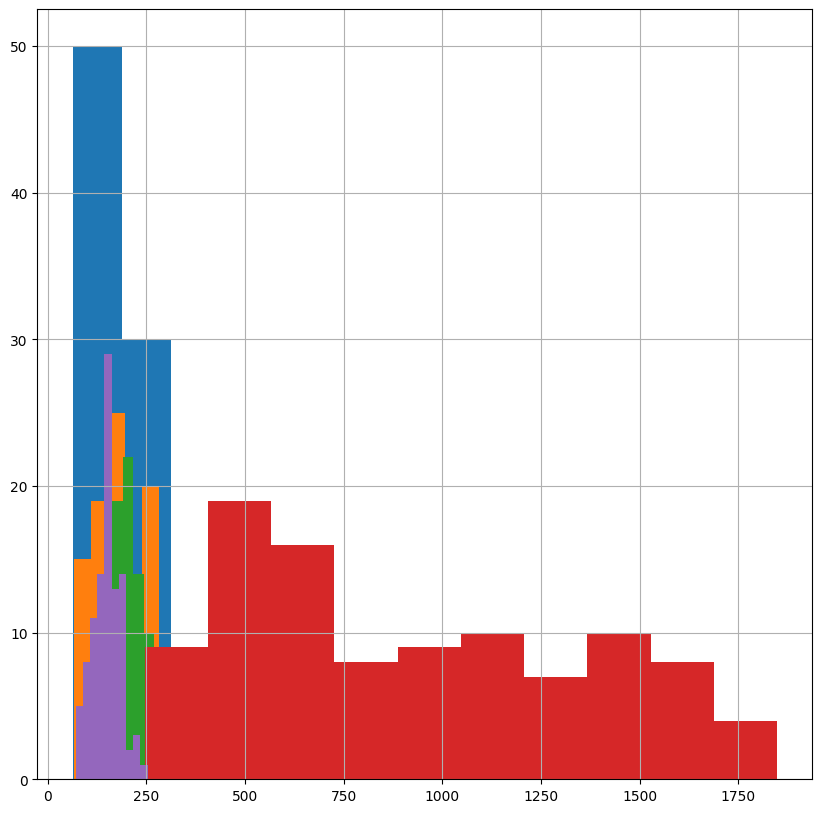

In [29]:
fset_cesium.groupby('classes')['amplitude'].hist()


array([[<Axes: title={'center': 'F'}>, <Axes: title={'center': 'N'}>],
       [<Axes: title={'center': 'O'}>, <Axes: title={'center': 'S'}>],
       [<Axes: title={'center': 'Z'}>, <Axes: >]], dtype=object)

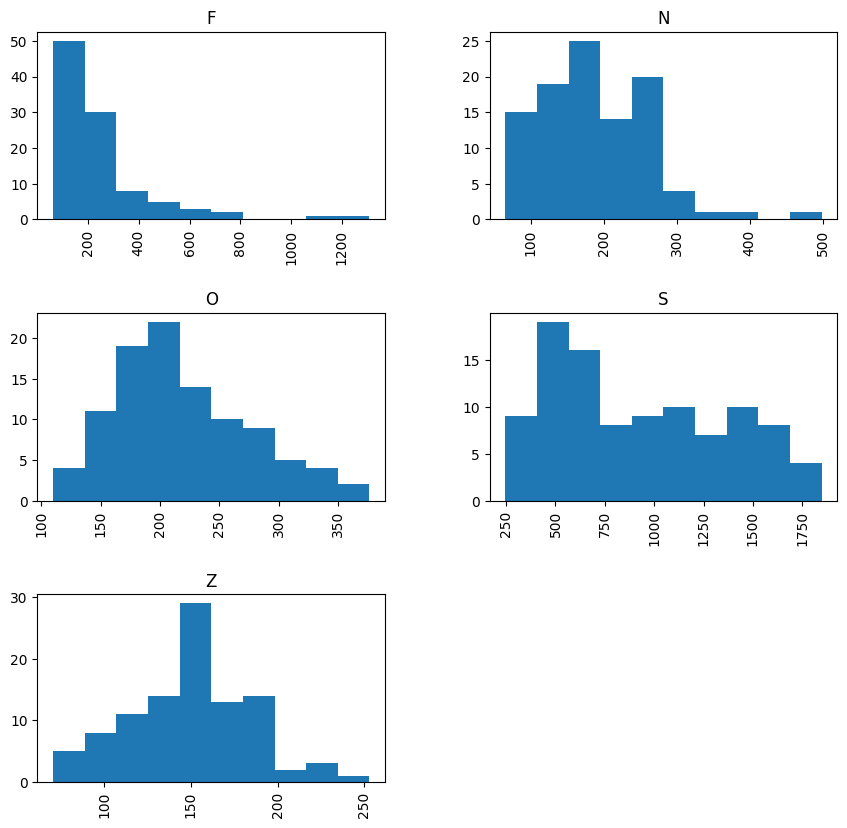

In [75]:
fset_cesium['amplitude'].hist(by=fset_cesium['classes'])

array([[<Axes: title={'center': 'F'}>, <Axes: title={'center': 'N'}>],
       [<Axes: title={'center': 'O'}>, <Axes: title={'center': 'S'}>],
       [<Axes: title={'center': 'Z'}>, <Axes: >]], dtype=object)

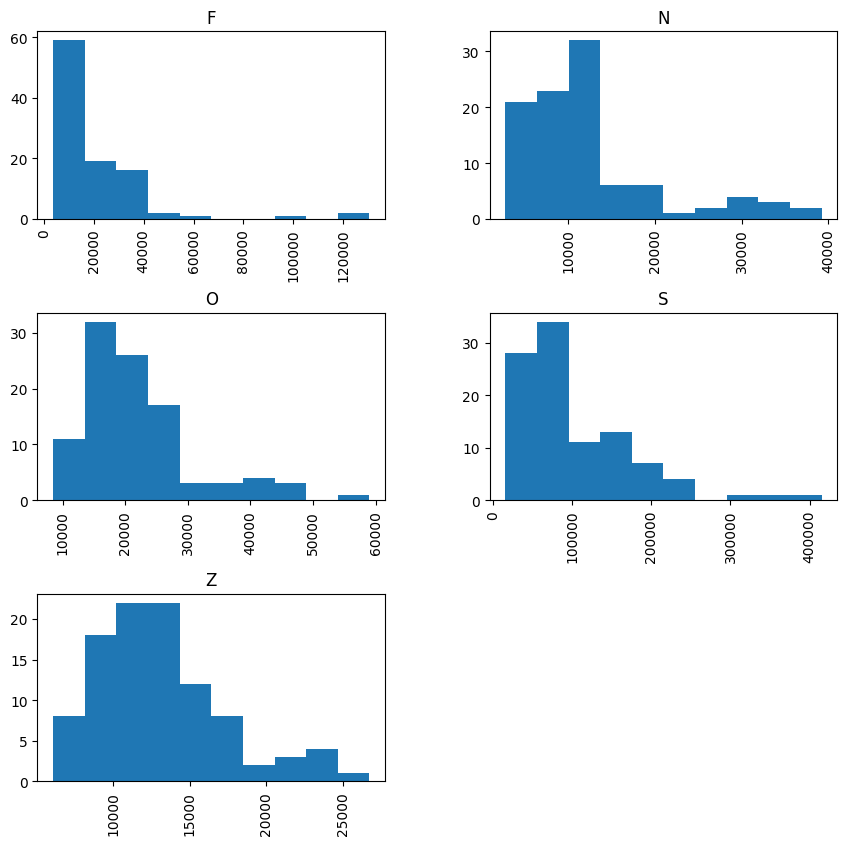

In [76]:
fset_cesium['max_slope'].hist(by=fset_cesium['classes'])

## Prepare data for training

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
     fset_cesium.iloc[:, 1:6].values, eeg["classes"], random_state=21)

In [82]:
X_train

array([[0.29777886258237735, 0.5875030510129363, -0.006265354056853621,
        101705.76271183933, 'S'],
       [0.2499389797412741, 0.6097144251891629, -0.9371639738206621,
        11802.033898305812, 'N'],
       [0.31559677813033926, 0.5303880888454967, -0.11512819282917286,
        13884.745762711651, 'O'],
       ...,
       [0.3151086160605321, 0.5250183060776178, -0.2699783367457087,
        5553.898305083376, 'F'],
       [0.3087625091530388, 0.5152550646814742, -0.18589588503012977,
        3297.6271186432546, 'N'],
       [0.31925799365389307, 0.4913351232609226, -0.14706356119512373,
        21868.474576272536, 'S']], dtype=object)

In [81]:
y_test

array(['O', 'S', 'N', 'F', 'S', 'S', 'Z', 'S', 'O', 'Z', 'F', 'O', 'S',
       'F', 'Z', 'N', 'Z', 'O', 'Z', 'Z', 'S', 'F', 'O', 'N', 'F', 'F',
       'Z', 'N', 'Z', 'N', 'S', 'Z', 'O', 'O', 'S', 'S', 'N', 'S', 'N',
       'S', 'N', 'O', 'N', 'S', 'Z', 'N', 'O', 'Z', 'Z', 'S', 'O', 'Z',
       'F', 'F', 'S', 'Z', 'N', 'O', 'N', 'F', 'Z', 'Z', 'N', 'Z', 'F',
       'Z', 'N', 'F', 'O', 'N', 'N', 'Z', 'N', 'O', 'N', 'F', 'O', 'F',
       'F', 'Z', 'S', 'N', 'Z', 'N', 'O', 'N', 'S', 'N', 'S', 'O', 'O',
       'S', 'O', 'N', 'N', 'S', 'N', 'S', 'Z', 'Z', 'S', 'S', 'O', 'F',
       'S', 'F', 'F', 'Z', 'F', 'Z', 'O', 'O', 'S', 'Z', 'Z', 'F', 'N',
       'Z', 'Z', 'F', 'S', 'N', 'Z', 'N', 'N'], dtype='<U1')

In [80]:
y_train

array(['S', 'N', 'O', 'F', 'F', 'Z', 'N', 'Z', 'O', 'O', 'O', 'O', 'N',
       'F', 'N', 'O', 'S', 'F', 'Z', 'S', 'O', 'S', 'F', 'O', 'N', 'Z',
       'O', 'S', 'N', 'Z', 'O', 'N', 'F', 'F', 'S', 'Z', 'F', 'O', 'Z',
       'O', 'S', 'Z', 'O', 'Z', 'N', 'S', 'Z', 'O', 'N', 'F', 'O', 'Z',
       'O', 'S', 'O', 'O', 'O', 'O', 'S', 'F', 'O', 'S', 'F', 'F', 'S',
       'Z', 'N', 'Z', 'F', 'S', 'F', 'S', 'S', 'S', 'Z', 'Z', 'O', 'F',
       'S', 'Z', 'O', 'Z', 'O', 'Z', 'N', 'F', 'Z', 'Z', 'Z', 'F', 'F',
       'Z', 'F', 'F', 'O', 'O', 'O', 'O', 'N', 'O', 'S', 'F', 'Z', 'N',
       'F', 'O', 'O', 'F', 'N', 'O', 'F', 'N', 'F', 'F', 'S', 'S', 'S',
       'N', 'F', 'S', 'O', 'S', 'O', 'F', 'F', 'F', 'F', 'O', 'S', 'S',
       'S', 'S', 'F', 'Z', 'N', 'O', 'O', 'Z', 'Z', 'Z', 'Z', 'O', 'N',
       'Z', 'Z', 'Z', 'N', 'N', 'F', 'Z', 'O', 'O', 'Z', 'S', 'O', 'N',
       'O', 'Z', 'Z', 'F', 'Z', 'N', 'Z', 'F', 'Z', 'Z', 'N', 'N', 'S',
       'F', 'S', 'O', 'F', 'F', 'O', 'O', 'S', 'N', 'F', 'O', 'F

## On Encoding the String Labels

In [ ]:
# Given dictionary mapping string labels to integer labels
label_mapping = {'F': 0, 'N': 1, 'S': 2, 'O': 3, 'Z': 4}

# Convert the last string label to integer label in each sample
for sample in X_train:
    sample[-1] = label_mapping[sample[-1]]




In [109]:
for sample in X_test:
    sample[-1] = label_mapping[sample[-1]]

In [111]:
y_train

array(['S', 'N', 'O', 'F', 'F', 'Z', 'N', 'Z', 'O', 'O', 'O', 'O', 'N',
       'F', 'N', 'O', 'S', 'F', 'Z', 'S', 'O', 'S', 'F', 'O', 'N', 'Z',
       'O', 'S', 'N', 'Z', 'O', 'N', 'F', 'F', 'S', 'Z', 'F', 'O', 'Z',
       'O', 'S', 'Z', 'O', 'Z', 'N', 'S', 'Z', 'O', 'N', 'F', 'O', 'Z',
       'O', 'S', 'O', 'O', 'O', 'O', 'S', 'F', 'O', 'S', 'F', 'F', 'S',
       'Z', 'N', 'Z', 'F', 'S', 'F', 'S', 'S', 'S', 'Z', 'Z', 'O', 'F',
       'S', 'Z', 'O', 'Z', 'O', 'Z', 'N', 'F', 'Z', 'Z', 'Z', 'F', 'F',
       'Z', 'F', 'F', 'O', 'O', 'O', 'O', 'N', 'O', 'S', 'F', 'Z', 'N',
       'F', 'O', 'O', 'F', 'N', 'O', 'F', 'N', 'F', 'F', 'S', 'S', 'S',
       'N', 'F', 'S', 'O', 'S', 'O', 'F', 'F', 'F', 'F', 'O', 'S', 'S',
       'S', 'S', 'F', 'Z', 'N', 'O', 'O', 'Z', 'Z', 'Z', 'Z', 'O', 'N',
       'Z', 'Z', 'Z', 'N', 'N', 'F', 'Z', 'O', 'O', 'Z', 'S', 'O', 'N',
       'O', 'Z', 'Z', 'F', 'Z', 'N', 'Z', 'F', 'Z', 'Z', 'N', 'N', 'S',
       'F', 'S', 'O', 'F', 'F', 'O', 'O', 'S', 'N', 'F', 'O', 'F

In [112]:
# Convert string labels to integer labels using label_mapping
y_train_encoded = np.array([label_mapping[label] for label in y_train])

In [113]:
# Convert string labels to integer labels using label_mapping
y_test_encoded = np.array([label_mapping[label] for label in y_test])

In [98]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

categorical_indices = [0, 1, 2, 3, 4]

# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder()

# Fit and transform X_train
X_train_encoded = onehot_encoder.fit_transform(X_train)
# Initialize LabelEncoder
label_encoder_y = LabelEncoder()

# Fit label encoder and transform y_train
y_train_encoded = label_encoder_y.fit_transform(y_train)


# Fit and transform X_train
X_test_encoded = onehot_encoder.fit_transform(X_test)

# Fit label encoder and transform y_train
y_test_encoded = label_encoder_y.fit_transform(y_test)





In [114]:
print(X_train)

print(type(X_train_encoded), X_train_encoded)

print(y_train)
print(type(y_train_encoded), y_train_encoded)


print(X_test)

print(type(X_test_encoded), X_test_encoded)

print(y_test)
print(type(y_test_encoded), y_test_encoded)


[[0.29777886258237735 0.5875030510129363 -0.006265354056853621
  101705.76271183933 2]
 [0.2499389797412741 0.6097144251891629 -0.9371639738206621
  11802.033898305812 1]
 [0.31559677813033926 0.5303880888454967 -0.11512819282917286
  13884.745762711651 3]
 ...
 [0.3151086160605321 0.5250183060776178 -0.2699783367457087
  5553.898305083376 0]
 [0.3087625091530388 0.5152550646814742 -0.18589588503012977
  3297.6271186432546 1]
 [0.31925799365389307 0.4913351232609226 -0.14706356119512373
  21868.474576272536 2]]
<class 'scipy.sparse._csr.csr_matrix'>   (0, 89)	1.0
  (0, 456)	1.0
  (0, 724)	1.0
  (0, 1173)	1.0
  (0, 1205)	1.0
  (1, 23)	1.0
  (1, 477)	1.0
  (1, 539)	1.0
  (1, 986)	1.0
  (1, 1203)	1.0
  (2, 148)	1.0
  (2, 351)	1.0
  (2, 641)	1.0
  (2, 1011)	1.0
  (2, 1204)	1.0
  (3, 31)	1.0
  (3, 517)	1.0
  (3, 561)	1.0
  (3, 1148)	1.0
  (3, 1202)	1.0
  (4, 191)	1.0
  (4, 302)	1.0
  (4, 639)	1.0
  (4, 908)	1.0
  (4, 1202)	1.0
  :	:
  (370, 128)	1.0
  (370, 361)	1.0
  (370, 789)	1.0
  (370,

625

## Try a random forest with these features

In [102]:
clf = RandomForestClassifier(n_estimators=10, max_depth=3,
                              random_state=21)

In [128]:
clf.fit(X_train, y_train_encoded)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [129]:
X_test

array([[0.3214547229680254, 0.532584818159629, 0.05164158419802332,
        8677.966101692775, 3],
       [0.23505003661215523, 0.5184281181352209, 1.1074396625496528,
        34017.62711865665, 2],
       [0.2753234073712473, 0.6399804735172077, -0.3481841003853402,
        29852.203389823146, 1],
       [0.3019282401757383, 0.5377105198926043, -0.19954826024434302,
        12322.71186440754, 0],
       [0.26336343666097145, 0.5845740785940933, -0.589169437804117,
        42869.15254238874, 2],
       [0.28313400048816206, 0.6470588235294118, -0.11024895362736382,
        93201.35593220555, 2],
       [0.303880888454967, 0.5357578716133756, -0.1318463160088896,
        10934.237288136268, 4],
       [0.3617280937271174, 0.39492311447400535, 0.046879961253473476,
        27595.93220339153, 2],
       [0.3126678057114962, 0.5391750061020258, -0.04044455438291556,
        14752.542372877717, 3],
       [0.3214547229680254, 0.5079326336343666, 0.039788323027199174,
        14578.983050843

In [130]:
clf.score(X_train, y_train_encoded)

0.888

In [131]:
clf.score(X_test, y_test_encoded)

0.912

In [132]:
np.unique(y_test_encoded, return_counts=True)

(array([0, 1, 2, 3, 4]), array([20, 29, 25, 21, 30], dtype=int64))

In [133]:
y_test_encoded

array([3, 2, 1, 0, 2, 2, 4, 2, 3, 4, 0, 3, 2, 0, 4, 1, 4, 3, 4, 4, 2, 0,
       3, 1, 0, 0, 4, 1, 4, 1, 2, 4, 3, 3, 2, 2, 1, 2, 1, 2, 1, 3, 1, 2,
       4, 1, 3, 4, 4, 2, 3, 4, 0, 0, 2, 4, 1, 3, 1, 0, 4, 4, 1, 4, 0, 4,
       1, 0, 3, 1, 1, 4, 1, 3, 1, 0, 3, 0, 0, 4, 2, 1, 4, 1, 3, 1, 2, 1,
       2, 3, 3, 2, 3, 1, 1, 2, 1, 2, 4, 4, 2, 2, 3, 0, 2, 0, 0, 4, 0, 4,
       3, 3, 2, 4, 4, 0, 1, 4, 4, 0, 2, 1, 4, 1, 1])

In [134]:
y_test_encoded.shape

(125,)

In [136]:
y_test_encoded.shape

(125,)

## Try XGBoost with these features

In [137]:
model = xgb.XGBClassifier(n_estimators=10, max_depth=3,
                              random_state=21)
model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [139]:
model.score(X_test, y_test_encoded)

1.0

In [138]:
model.score(X_train, y_train_encoded)

1.0

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

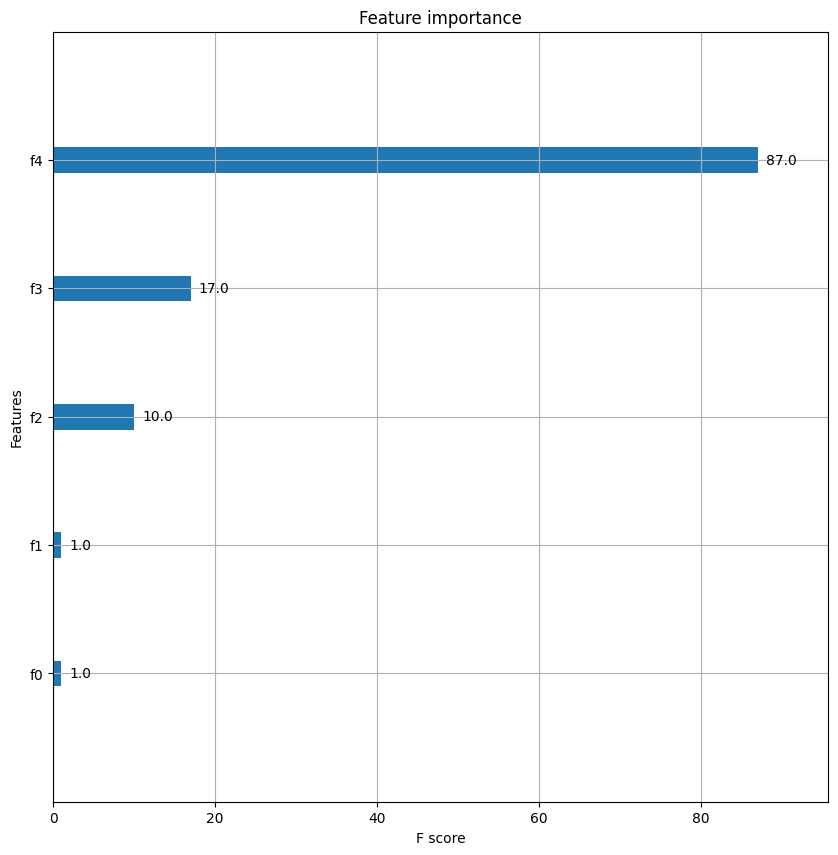

In [153]:
xgb.plot_importance(model)

## Time Series Forecasting with Decision Trees

In [145]:
ap = pd.read_csv("../data/AirPassengers.csv", parse_dates=[1])

C:\Users\mhuzaifa\AppData\Local\Temp\ipykernel_15996\295041429.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ap = pd.read_csv("../data/AirPassengers.csv", parse_dates=[1])


In [146]:
ap.head()

,1949-01,112
0,1949-02,118
1,1949-03,132
2,1949-04,129
3,1949-05,121
4,1949-06,135


In [150]:
type(ap)

pandas.core.frame.DataFrame

In [147]:
help(ap.set_index)

Help on method set_index in module pandas.core.frame:

set_index(keys, *, drop: 'bool' = True, append: 'bool' = False, inplace: 'bool' = False, verify_integrity: 'bool' = False) -> 'DataFrame | None' method of pandas.core.frame.DataFrame instance
    Set the DataFrame index using existing columns.
    
    Set the DataFrame index (row labels) using one or more existing
    columns or arrays (of the correct length). The index can replace the
    existing index or expand on it.
    
    Parameters
    ----------
    keys : label or array-like or list of labels/arrays
        This parameter can be either a single column key, a single array of
        the same length as the calling DataFrame, or a list containing an
        arbitrary combination of column keys and arrays. Here, "array"
        encompasses :class:`Series`, :class:`Index`, ``np.ndarray``, and
        instances of :class:`~collections.abc.Iterator`.
    drop : bool, default True
        Delete columns to be used as the new in

In [148]:
key_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ap.set_index('Month', inplace=True)

KeyError: "None of ['Month'] are in the columns"

In [149]:
ap.head()

,1949-01,112
0,1949-02,118
1,1949-03,132
2,1949-04,129
3,1949-05,121
4,1949-06,135


TypeError: unhashable type: 'numpy.ndarray'

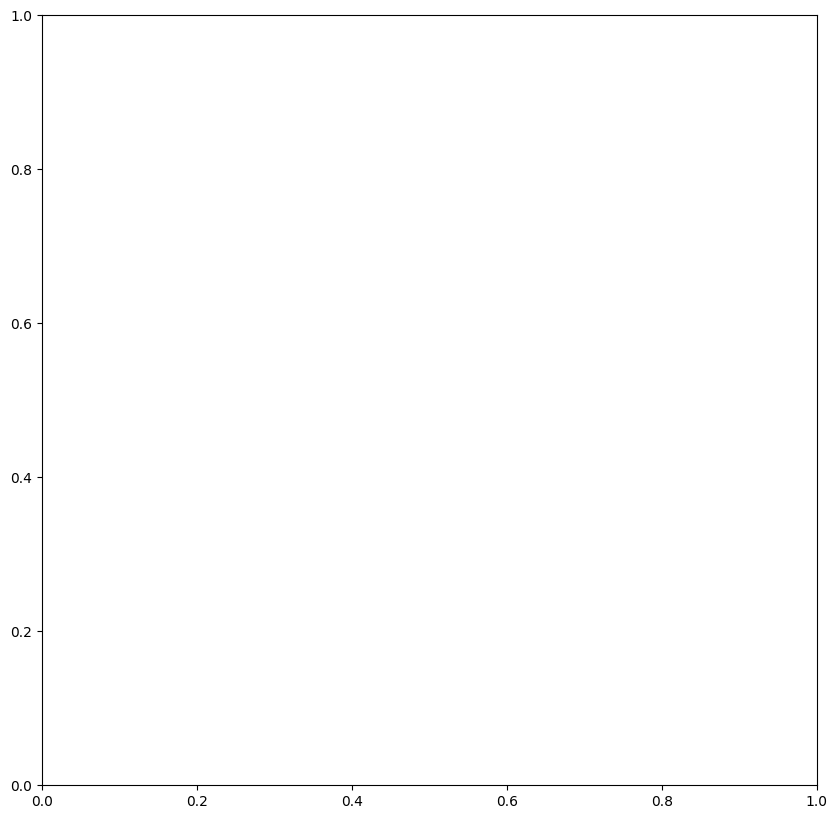

In [151]:
plt.plot(ap)

In [152]:
plt.plot(np.diff(np.log(ap.values[:, 0])))

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log method

In [ ]:
ts = np.diff(np.log(ap.values[:, 0]))

## Exercise: now that we have 1 time series, how can we convert it to many samples?

In [ ]:
NSTEPS = 12

In [ ]:
ts.shape

In [ ]:
vals = np.hstack([np.expand_dims(np.array(ts, dtype = np.float32), axis = 1) for _ in range(NSTEPS )])

In [ ]:
ts[0:NSTEPS]

In [ ]:
vals.shape

In [ ]:
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag),lag] = vals[lag:,lag]
    vals[(nrow - lag):, lag] = np.nan

In [ ]:
vals

In [ ]:
vals = vals[:(vals.shape[0] - NSTEPS + 1), :]

In [ ]:
vals.shape

In [ ]:
vals[-1]

In [ ]:
ts[-NSTEPS:]

In [ ]:
vals.shape

## Exercise: now that we have the time series broken down into a set of samples, how to featurize?

In [ ]:
measures = [vals[i][0:(NSTEPS - 1)] for i in range(vals.shape[0])]

In [ ]:
times = [[j for j in range(NSTEPS - 1)] for i in range(vals.shape[0])]

In [ ]:
measures[0]

In [ ]:
len(measures[0])

In [ ]:
features_to_use = [
                   "amplitude",
                   "percent_beyond_1_std",
                   "skew",
                   "max_slope",
                   "percent_amplitude"]
fset_ap = ft.featurize_time_series(times=times,
                                    values=measures,
                                    errors=None,
                                    features_to_use=features_to_use,
                                    scheduler = None)

In [ ]:
fset_ap.columns = fset_ap.columns.droplevel(-1)

In [ ]:
fset_ap.head()

In [ ]:
plt.hist(fset_ap.amplitude)

In [ ]:
plt.hist(fset_ap.percent_amplitude)

In [ ]:
plt.hist(fset_ap['skew'])

## Exercise: can you fit an XGBRegressor to this problem? Let's use the first 100 'time series' as the training data

In [ ]:
outcomes = vals[:, -1]

In [ ]:
X_train, y_train = fset_ap.iloc[:100, :], outcomes[:100]
X_test, y_test   = fset_ap.iloc[100:, :], outcomes[100:]

In [ ]:
X_train.shape

In [ ]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)

In [ ]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

### RMSE can be hard to digest .... How does the model perform?

In [ ]:
plt.scatter(model.predict(X_test), y_test)

In [ ]:
plt.scatter(model.predict(X_train), y_train)

In [ ]:
pearsonr(model.predict(X_train), y_train)

In [ ]:
pearsonr(model.predict(X_test), y_test)

In [ ]:
xgb.plot_importance(model)

### What went wrong? Let's revisit the feature set

In [ ]:
fset_ap.head()

In [ ]:
plt.plot(vals[0])
plt.plot(vals[1])
plt.plot(vals[2])

## We need to find a way to generate features that encode positional information

### now we will generate our own features

In [ ]:
vals.shape

In [ ]:
feats = np.zeros( (vals.shape[0], 6), dtype = np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0]
    feats[i, 1] = np.where(vals[i] == np.min(vals[i]))[0][0]
    feats[i, 2] = feats[i, 0] - feats[i, 1]
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]

In [ ]:
feats[0:3]

### How do these look compared to the first set of features?

In [ ]:
pd.DataFrame(feats[0:3])

In [ ]:
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test   = feats[100:, :], outcomes[100:]

In [ ]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

In [ ]:
plt.scatter(model.predict(X_test), y_test)

In [ ]:
print(pearsonr(model.predict(X_test), y_test))
print(spearmanr(model.predict(X_test), y_test))

In [ ]:
plt.scatter(model.predict(X_train), y_train)

In [ ]:
print(pearsonr(model.predict(X_train), y_train))
print(spearmanr(model.predict(X_train), y_train))